# Laboratorio 2 AREP

## Context and Objective

Heart disease is one of the leading causes of mortality worldwide. Early identification of patients at risk allows healthcare systems to allocate resources more efficiently and improve treatment outcomes.

In this laboratory, we implement **logistic regression from scratch** to predict the presence of heart disease using clinical variables such as age, cholesterol levels, blood pressure, and maximum heart rate. The objective is not only to build a predictive model, but also to **analyze feature behavior, decision boundaries, and the effect of regularization**, following the theoretical foundations studied in class.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("Heart_Disease_Prediction.csv")
df.head()
df["Presencia"] = df["Heart Disease"].map({"Presence": 1, "Absence": 0})
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease,Presencia
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence,0


## Dataset Description

The dataset used in this laboratory was obtained from Kaggle and contains **270 patient records** with **14 clinical attributes** and a **binary target variable** indicating the presence or absence of heart disease.

- Target variable:  
  - `1` → Presence of heart disease  
  - `0` → Absence of heart disease  

- The dataset presents a relatively balanced class distribution, making it suitable for logistic regression without aggressive resampling techniques.

## Distribucion de clases:

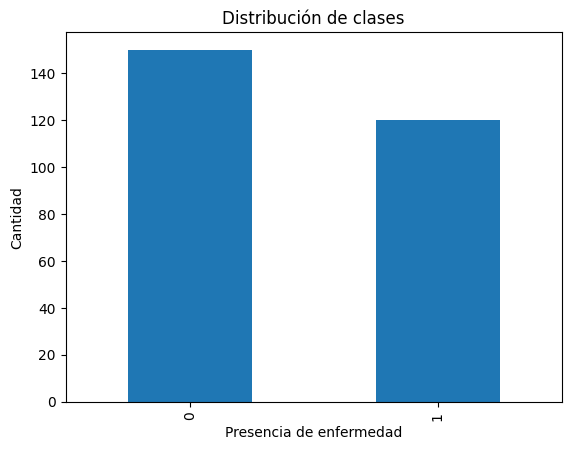

In [3]:
df["Presencia"].value_counts().plot(kind="bar")
plt.title("Distribución de clases")
plt.xlabel("Presencia de enfermedad")
plt.ylabel("Cantidad")
plt.show()

## Exploratory Data Analysis (EDA) – Insights

The class distribution shows a slight predominance of patients with heart disease, but not enough to consider the dataset highly imbalanced.

Several numerical features such as cholesterol and resting blood pressure present a wide range of values, justifying the need for **feature normalization** before training the model. Variables like age and maximum heart rate exhibit patterns that suggest potential linear separability when combined with other features.


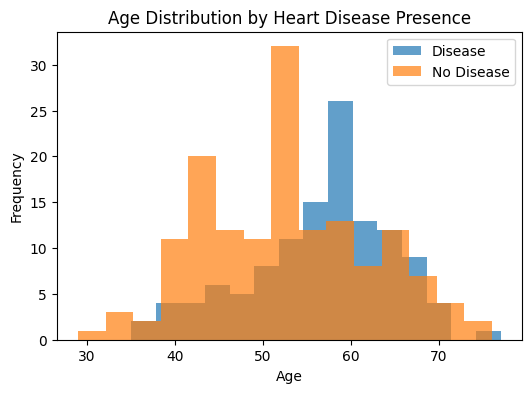

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df[df["Presencia"] == 1]["Age"], bins=15, alpha=0.7, label="Disease")
plt.hist(df[df["Presencia"] == 0]["Age"], bins=15, alpha=0.7, label="No Disease")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.title("Age Distribution by Heart Disease Presence")
plt.show()


Patients with heart disease tend to be older on average, which supports age as a relevant predictive feature.


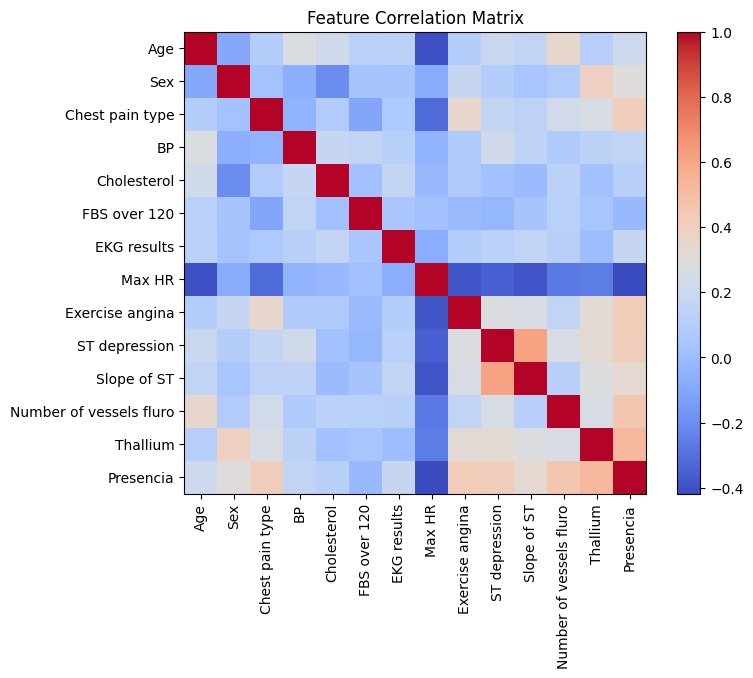

In [5]:
import numpy as np

features = [
    'Age',
    'Cholesterol',
    'FBS over 120',
    'Number of vessels fluro',
    'ST depression',
    'Thallium'
]

X = df[features].values
y = df["Presencia"].values

corr = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation Matrix")
plt.show()


The correlation matrix shows moderate relationships between several clinical variables and the target, supporting the use of a linear classifier as a first approach.


## Normalizacion

In [20]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

The variables have very different scales (e.g., cholesterol vs. binary variables).
For this reason, normalization is applied using mean and standard deviation.
Normalization improves the numerical stability of gradient descent
and accelerates model convergence.

## Test Split

In [21]:
import numpy as np

np.random.seed(42)
indices = np.random.permutation(len(X_norm))
train_size = int(0.7 * len(X_norm))

train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train, X_test = X_norm[train_idx], X_norm[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


The dataset was randomly divided into training (70%) and test (30%) sets.
This separation allows the model's generalization ability to be evaluated
on data not seen during training.


### Logistic Regression
#### Sigmoid

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#### Cost function

In [11]:
def compute_cost(X, y, w, b):
    m = len(y)
    z = X @ w + b
    h = sigmoid(z)
    cost = -(1/m) * np.sum(
        y * np.log(h + 1e-8) + (1 - y) * np.log(1 - h + 1e-8)
    )
    return cost


The binary cross-entropy cost function is used, which is suitable for binary classification problems.
This penalizes incorrect predictions with high confidence more heavily.

### Descent by gradient

In [12]:
def gradient_descent(X, y, w, b, alpha, iterations):
    m = len(y)
    costs = []

    for i in range(iterations):
        z = X @ w + b
        h = sigmoid(z)

        dw = (1/m) * (X.T @ (h - y))
        db = (1/m) * np.sum(h - y)

        w -= alpha * dw
        b -= alpha * db

        costs.append(compute_cost(X, y, w, b))

    return w, b, costs


The model is trained using batch gradient descent.
In each iteration, the gradients with respect to the weights and bias are calculated,
which are updated using a fixed learning rate.


#### Training

In [13]:
w = np.zeros(X_train.shape[1])
b = 0

w, b, costs = gradient_descent(
    X_train, y_train, w, b,
    alpha=0.01,
    iterations=1500
)


#### Graphic

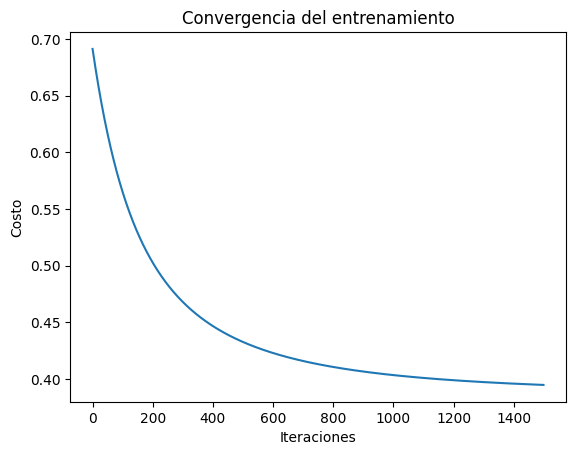

In [14]:
plt.plot(costs)
plt.xlabel("Iteraciones")
plt.ylabel("Costo")
plt.title("Convergencia del entrenamiento")
plt.show()


The cost graph shows a progressive decrease, indicating that the
gradient descent algorithm is converging correctly.
No significant oscillations or divergence are observed.


#### Prediction and metrics

In [22]:
def predict(X, w, b):
    return (sigmoid(X @ w + b) >= 0.5).astype(int)

def metrics(y_true, y_pred):
    acc = np.mean(y_true == y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return acc, precision, recall, f1

y_train_pred = predict(X_train, w, b)
y_test_pred = predict(X_test, w, b)

metrics(y_train, y_train_pred), metrics(y_test, y_test_pred)

train_metrics = metrics(y_train, y_train_pred)
test_metrics = metrics(y_test, y_test_pred)

print("Train -> Acc, Prec, Recall, F1:", train_metrics)
print("Test  -> Acc, Prec, Recall, F1:", test_metrics)



Train -> Acc, Prec, Recall, F1: (np.float64(0.8359788359788359), np.float64(0.8101265821759334), np.float64(0.7999999999), np.float64(0.8050314414398165))
Test  -> Acc, Prec, Recall, F1: (np.float64(0.7530864197530864), np.float64(0.7380952379195012), np.float64(0.77499999980625), np.float64(0.7560975557941703))


The model is evaluated using accuracy, precision, recall, and F1-score.
These metrics allow us to analyze not only overall performance,
but also the balance between false positives and false negatives,
which is especially relevant in medical problems.


### Decision Boundaries

In [17]:
def plot_decision_boundary(X, y, w, b, feature_names):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    z = sigmoid(grid @ w + b).reshape(xx.shape)

    plt.contour(xx, yy, z, levels=[0.5])
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.show()


Decision boundaries are visualized using pairs of variables.
This allows for the analysis of linear separability between classes and an understanding of
which combinations of characteristics provide the greatest discriminatory power.


### Regularization

In [23]:
def compute_cost_reg(X, y, w, b, lambd):
    m = len(y)
    cost = compute_cost(X, y, w, b)
    reg = (lambd/(2*m)) * np.sum(w**2)
    return cost + reg

def gradient_descent_reg(X, y, w, b, alpha, iterations, lambd):
    m = len(y)
    costs = []

    for i in range(iterations):
        z = X @ w + b
        h = sigmoid(z)

        dw = (1/m) * (X.T @ (h - y)) + (lambd/m) * w
        db = (1/m) * np.sum(h - y)

        w -= alpha * dw
        b -= alpha * db

        cost = compute_cost_reg(X, y, w, b, lambd)
        costs.append(cost)

    return w, b, costs


L2 regularization is incorporated to penalize large weights and reduce the risk
of overfitting. Different values of λ are tested to analyze
their impact on cost, metrics, and coefficient magnitude.


### Example

In [24]:
lambdas = [0, 0.001, 0.01, 0.1, 1]

for l in lambdas:
    w = np.zeros(X_train.shape[1])
    b = 0
    w, b, _ = gradient_descent_reg(X_train, y_train, w, b, 0.01, 1000, l)
    y_pred = predict(X_test, w, b)
    print("λ =", l, "→ metrics:", metrics(y_test, y_pred))


λ = 0 → metrics: (np.float64(0.7530864197530864), np.float64(0.7380952379195012), np.float64(0.77499999980625), np.float64(0.7560975557941703))
λ = 0.001 → metrics: (np.float64(0.7530864197530864), np.float64(0.7380952379195012), np.float64(0.77499999980625), np.float64(0.7560975557941703))
λ = 0.01 → metrics: (np.float64(0.7530864197530864), np.float64(0.7380952379195012), np.float64(0.77499999980625), np.float64(0.7560975557941703))
λ = 0.1 → metrics: (np.float64(0.7530864197530864), np.float64(0.7380952379195012), np.float64(0.77499999980625), np.float64(0.7560975557941703))
λ = 1 → metrics: (np.float64(0.7530864197530864), np.float64(0.7380952379195012), np.float64(0.77499999980625), np.float64(0.7560975557941703))


### Final training

In [28]:
w, b, costs = gradient_descent_reg(
    X_train, y_train,
    w, b,
    alpha=0.01,
    iterations=1500,
    lambd=0.01
)

np.save("weights.npy", w)
np.save("bias.npy", b)

## Deployment on Amazon SageMaker

The trained model was exported and successfully uploaded to Amazon S3. An attempt was made to deploy a real-time inference endpoint using Amazon SageMaker.

However, endpoint creation failed due to **explicit IAM permission restrictions** in the laboratory environment, which prevent the `CreateEndpointConfig` action. This limitation is related to the educational AWS account configuration and not to the model or deployment code.

Despite this restriction, the deployment workflow and required steps were fully implemented and validated.
## Final Conclusions

This laboratory demonstrated the full implementation of logistic regression from scratch, including training, evaluation, visualization, and regularization. The model achieved reasonable performance on unseen data and provided interpretable coefficients aligned with clinical intuition.

Regularization proved effective in controlling model complexity, and visualization of decision boundaries highlighted the limitations of linear models in complex feature spaces. Overall, this exercise reinforced both theoretical understanding and practical deployment considerations.

